In [1]:
# --- Cell 1: imports & user controls ---

from astroquery.mast import Catalogs
import pandas as pd
import lightkurve as lk
import numpy as np
import matplotlib.pyplot as plt

KOI_CSV   = "Kepler Objects of Interest.csv"
N_STARS   = 1          # <-- how many unique KICs to process
EXPTIME   = 1800
DO_PLOTS  = True
POINTSIZE = 2
ALPHA     = 0.5
SAVE_SUMMARY = True
SUMMARY_CSV  = "koi_summary.csv"

# brightness normalization
BRIGHTNESS_MODE = "flux"   # "flux" or "mmag"
CLIP_PERCENTILE = 0.5      # None to disable robust clipping


/Users/ssarfaraz/coding/nasa_space_apps_challenge_hackathon_2025_10_04/data_cleaning/.venv/lib/python3.12/site-packages/lightkurve/prf/__init__.py:7: UserWarning: Warning: the tpfmodel submodule is not available without oktopus installed, which requires a current version of autograd. See #1452 for details.
  warnings.warn(


In [2]:
# --- Cell 2: helper functions ---

def fetch_lightcurve(kepid: int, exptime: int | None = None):
    """Search, download (all), and stitch a Kepler light curve for a given KIC."""
    q = f"KIC {kepid}"
    search = lk.search_lightcurve(q, mission="Kepler", exptime=exptime) if exptime else lk.search_lightcurve(q, mission="Kepler")
    if len(search) == 0 and exptime is not None:
        # fall back if that cadence isn't available
        search = lk.search_lightcurve(q, mission="Kepler")
    if len(search) == 0:
        raise RuntimeError(f"No Kepler light curves found for {q}")
    dl = search.download_all()  # LightCurveCollection or LightCurve
    lc = dl.stitch() if hasattr(dl, "stitch") else dl
    return lc

# --- NEW helper: normalize any 1D array to [-1, 1] ---
def normalize_to_unit_symmetric(x, *, clip_percentile=None):
    """
    Normalize array to [-1, 1] centered on 0.
    If clip_percentile is set (e.g., 0.5), it clips extremes before scaling for robustness.
    """
    x = np.asarray(x, dtype=float)

    if clip_percentile is not None:
        lo = np.nanpercentile(x, clip_percentile)
        hi = np.nanpercentile(x, 100 - clip_percentile)
        m = (x >= lo) & (x <= hi) & np.isfinite(x)
        scale = np.nanmax(np.abs(x[m])) if np.any(m) else np.nanmax(np.abs(x))
    else:
        scale = np.nanmax(np.abs(x))

    if not np.isfinite(scale) or scale == 0:
        return np.zeros_like(x)

    return x / scale  # now in [-1, 1]

# --- UPDATED: prepare_flux_time now returns time and flux in [-1, 1] ---
def prepare_flux_time(lc):
    """
    Return time (BKJD) and flux normalized to [-1, 1].
    Uses PDCSAP if available. Robust to version differences.
    """
    tbl = lc.to_table()
    colnames = set(tbl.colnames)

    # pick flux column
    if "pdcsap_flux" in colnames:
        raw_flux = tbl["pdcsap_flux"].astype(float)
    elif "flux" in colnames:
        raw_flux = tbl["flux"].astype(float)
    else:
        raise RuntimeError(f"No suitable flux column found. Available: {sorted(colnames)}")

    if "time" not in colnames:
        raise RuntimeError(f"No 'time' column found. Available: {sorted(colnames)}")

    time = tbl["time"].value.astype(float)
    flux = np.asarray(raw_flux, dtype=float)

    # finite mask
    m = np.isfinite(time) & np.isfinite(flux)
    time = time[m]
    flux = flux[m]

    # center on 0 by removing the median fractional baseline, then scale to [-1, 1]
    # 1) relative flux around 1
    med = np.nanmedian(flux)
    if not np.isfinite(med) or med == 0:
        raise RuntimeError("Median flux is non-finite or zero; cannot normalize.")
    rel = flux / med  # ~1 +/- small variations

    # 2) deviations around 0
    dev = rel - 1.0

    # 3) scale symmetrically to [-1, 1]
    dev_norm = normalize_to_unit_symmetric(dev, clip_percentile=0.5)  # adjust/disable clipping if you want

    # dev_norm is now in [-1, 1]
    return time, dev_norm

def flux_to_mmag(flux_norm: np.ndarray):
    """Convert normalized flux to mmag (mean-subtracted)."""
    # m = -2.5 * log10(F)
    mag = -2.5 * np.log10(flux_norm)
    mmag = (mag - np.nanmean(mag)) * 1000.0
    return mmag

def compute_phase(time_bkjd: np.ndarray, period_days: float, epoch_bkjd: float):
    """Compute orbital phase in [0,1)."""
    return ((time_bkjd - epoch_bkjd) / period_days) % 1.0

def process_one_koi(row: pd.Series, exptime: int | None, do_plot: bool, i: int | None = None):
    """End-to-end for a single KOI row: download, clean, mmag, phase, optional plot."""
    kepid  = int(row["kepid"])
    period = float(row["koi_period"])
    epoch  = float(row["koi_time0bk"])

    print(f"period, epoch = {period}, {epoch}")

    print(f"[{i}] KIC {kepid} | P={period:.6f} d | epoch (BKJD)={epoch:.6f}")

    lc = fetch_lightcurve(kepid, exptime=exptime)
    time, flux_norm = prepare_flux_time(lc)
    mmag  = flux_to_mmag(flux_norm)
    phase = compute_phase(time, period, epoch)

    if do_plot:
        plt.figure(figsize=(7,4))
        plt.scatter(phase, mmag, s=POINTSIZE, alpha=ALPHA)
        plt.gca().invert_yaxis()  # magnitudes: up = brighter
        plt.xlabel("Orbital Phase")
        plt.ylabel("Relative Brightness (mmag)")
        plt.title(f"KIC {kepid} — Phase-folded (P={period:.6f} d)")
        plt.show()

    return {
        "kepid": kepid,
        "koi_period_days": period,
        "koi_epoch_bkjd": epoch,
        "n_points": len(time),
        "mmag_mean": float(np.nanmean(mmag)),
        "mmag_std":  float(np.nanstd(mmag)),
        "mmag_ptp":  float(np.nanmax(mmag) - np.nanmin(mmag)),
    }


# --- Cell 2: helpers ---

def fetch_lightcurve(kepid: int, exptime: int | None = None):
    q = f"KIC {kepid}"
    search = lk.search_lightcurve(q, mission="Kepler", exptime=exptime) if exptime else lk.search_lightcurve(q, mission="Kepler")
    if len(search) == 0 and exptime is not None:
        search = lk.search_lightcurve(q, mission="Kepler")
    if len(search) == 0:
        raise RuntimeError(f"No Kepler light curves found for {q}")
    dl = search.download_all()
    lc = dl.stitch() if hasattr(dl, "stitch") else dl
    return lc

def normalize_to_unit_symmetric(x, clip_percentile=None):
    x = np.asarray(x, dtype=float)
    if clip_percentile is not None:
        lo = np.nanpercentile(x, clip_percentile)
        hi = np.nanpercentile(x, 100 - clip_percentile)
        m = np.isfinite(x) & (x >= lo) & (x <= hi)
        scale = np.nanmax(np.abs(x[m])) if np.any(m) else np.nanmax(np.abs(x))
    else:
        scale = np.nanmax(np.abs(x))
    if not np.isfinite(scale) or scale == 0:
        return np.zeros_like(x)
    return x / scale

def prepare_time_and_relflux(lc):
    tbl = lc.to_table()
    cn = set(tbl.colnames)
    if "time" not in cn:
        raise RuntimeError(f"No 'time' column. Available: {sorted(cn)}")
    if "pdcsap_flux" in cn:
        raw_flux = np.asarray(tbl["pdcsap_flux"], dtype=float)
    elif "flux" in cn:
        raw_flux = np.asarray(tbl["flux"], dtype=float)
    else:
        raise RuntimeError(f"No flux column. Available: {sorted(cn)}")
    time = tbl["time"].value.astype(float)
    m = np.isfinite(time) & np.isfinite(raw_flux)
    time = time[m]; raw_flux = raw_flux[m]
    med = np.nanmedian(raw_flux)
    if not np.isfinite(med) or med == 0:
        raise RuntimeError("Median flux is non-finite or zero.")
    rel = raw_flux / med     # ~1 +/- small variations
    return time, rel

def brightness_normalized(rel_flux, mode="flux", clip_percentile=None):
    if mode == "flux":
        dev = rel_flux - 1.0
        return normalize_to_unit_symmetric(dev, clip_percentile)
    elif mode == "mmag":
        mag = -2.5 * np.log10(rel_flux)
        mag_dev = mag - np.nanmedian(mag)
        return normalize_to_unit_symmetric(mag_dev, clip_percentile)
    else:
        raise ValueError("BRIGHTNESS_MODE must be 'flux' or 'mmag'")

def compute_phase(time_bkjd: np.ndarray, period_days: float, epoch_bkjd: float):
    return ((time_bkjd - epoch_bkjd) / period_days) % 1.0


In [3]:
# --- Cell 3: load KOI table ---

df = pd.read_csv(KOI_CSV, comment="#")
print(f"Loaded {len(df)} KOI rows from: {KOI_CSV}")
display(df.head(4)[["kepid","kepoi_name","koi_period","koi_time0bk"]])

# We'll process by unique kepid (stars)
unique_kics = df["kepid"].dropna().astype(int).unique().tolist()
if N_STARS > len(unique_kics):
    print(f"N_STARS={N_STARS} > {len(unique_kics)} available; processing all.")
    N_STARS = len(unique_kics)


Loaded 9564 KOI rows from: Kepler Objects of Interest.csv


,kepid,kepoi_name,koi_period,koi_time0bk
0,10797460,K00752.01,9.488036,170.538750
1,10797460,K00752.02,54.418383,162.513840
2,10811496,K00753.01,19.899140,175.850252
3,10848459,K00754.01,1.736952,170.307565


In [4]:
# --- Cell 4: per-star overlay plotting of all planets ---

def plot_star_with_planets(kepid: int, subdf: pd.DataFrame, exptime: int | None = EXPTIME):
    print(f"\nKIC {kepid}: {len(subdf)} planet(s) — downloading light curve once...")
    lc = fetch_lightcurve(kepid, exptime=exptime)
    time, rel_flux = prepare_time_and_relflux(lc)
    bnorm = brightness_normalized(rel_flux, mode=BRIGHTNESS_MODE, clip_percentile=CLIP_PERCENTILE)

    if DO_PLOTS:
        fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(10, 8))
        
        # Plot 1: Raw light curve over time
        ax1.scatter(time, bnorm, s=POINTSIZE, alpha=ALPHA, c='gray')
        ax1.set_xlabel("Time (BKJD)")
        ylab = "Normalized Brightness [-1, 1] (flux)" if BRIGHTNESS_MODE=="flux" else "Normalized Brightness [-1, 1] (mmag)"
        ax1.set_ylabel(ylab)
        ax1.set_title(f"KIC {kepid} — Light Curve")
        ax1.set_ylim(-1.05, 1.05)
        ax1.grid(alpha=0.3)

    summaries = []
    for _, row in subdf.iterrows():
        pname = str(row.get("kepoi_name", "KOI"))
        period = float(row["koi_period"])
        epoch  = float(row["koi_time0bk"])
        phase = compute_phase(time, period, epoch)

        # Plot this planet's phase-folded brightness on the same axes
        if DO_PLOTS:
            ax2.scatter(phase, bnorm, s=POINTSIZE, alpha=ALPHA, label=pname)

        summaries.append({
            "kepid": kepid,
            "planet": pname,
            "koi_period_days": period,
            "koi_epoch_bkjd": epoch,
            "n_points": len(time),
            "brightness_min": float(np.nanmin(bnorm)),
            "brightness_max": float(np.nanmax(bnorm)),
            "brightness_std": float(np.nanstd(bnorm)),
        })

    if DO_PLOTS:
        ax2.set_xlabel("Orbital Phase")
        ax2.set_ylabel(ylab)
        ax2.set_title(f"KIC {kepid} — Phase-folded (all planets)")
        ax2.set_ylim(-1.05, 1.05)
        ax2.legend(markerscale=4, fontsize=8, loc="best", frameon=True)
        ax2.grid(alpha=0.3)
        plt.tight_layout()
        plt.show()

    return summaries



KIC 10797460: 2 planet(s) — downloading light curve once...


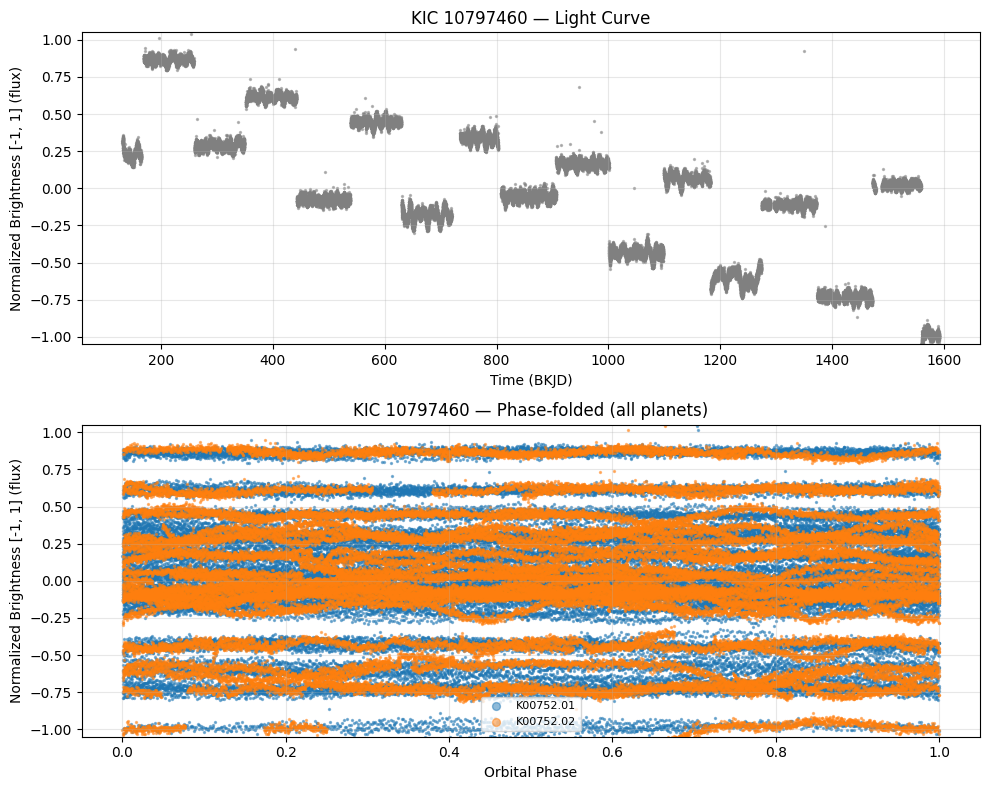


Finished. Summary rows: 2


,kepid,planet,koi_period_days,koi_epoch_bkjd,n_points,brightness_min,brightness_max,brightness_std
0,10797460,K00752.01,9.488036,170.53875,64814,-1.120018,1.458788,0.441279
1,10797460,K00752.02,54.418383,162.51384,64814,-1.120018,1.458788,0.441279


In [5]:
# --- Cell 5: run batch over unique stars ---

results = []
for kepid in unique_kics[:N_STARS]:
    sub = df[df["kepid"] == kepid].copy()
    try:
        results.extend(plot_star_with_planets(int(kepid), sub, exptime=EXPTIME))
    except Exception as e:
        print(f"!! Skipped KIC {kepid}: {e}")

summary = pd.DataFrame(results)
print("\nFinished. Summary rows:", len(summary))
display(summary)
